In [45]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast import GridGenerator
from scalecast.notebook import tune_test_forecast

In [46]:
# read in data
data = pd.read_csv('csv/82000278_Toamnei_CO2_2021_08_1week_date.csv')

In [47]:
# set graph sizes
sns.set(rc={'figure.figsize':(30,15)})

In [48]:
data.head()

,time,latitude,longitude,altitude,co2,date
0,1627862426,45.651464,25.615426,538,612,02-08-21 00:00
1,1627862486,45.651464,25.615426,538,610,02-08-21 00:01
2,1627862546,45.651464,25.615426,538,606,02-08-21 00:02
3,1627862606,45.651464,25.615426,538,609,02-08-21 00:03
4,1627862666,45.651464,25.615426,538,606,02-08-21 00:04


In [49]:
result = data.dtypes
result

time           int64
latitude     float64
longitude    float64
altitude       int64
co2            int64
date          object
dtype: object

In [50]:
# the dataset is in sequential order
# data = data.sort_values('time')
# data

In [51]:
# data['date'] = pd.to_datetime(data['date'])
# data

In [52]:
# import matplotlib.pyplot as plt
# plt.close("all")
# # fig = plt.figure(figsize=(20,10), frameon=True)
# plt.figure(figsize=(30,15))
# plt.plot(data.get('date'), data.get('co2'), label="CO2 values", color = "blue")
# # plt.scatter(dataframe.get('_source.TimeStamp'), dataframe.get('_source.Value'), color = "red")
# plt.xlabel("TimeStamp", fontsize=16)
# plt.ylabel("Value", fontsize=16)
# plt.title("CO2 values on 1 week", fontsize=18)
# plt.legend(fontsize=16)
# # plt.savefig('plots_from_csv/CSV_Tests_1month.jpg', bbox_inches = 'tight')
# plt.show()

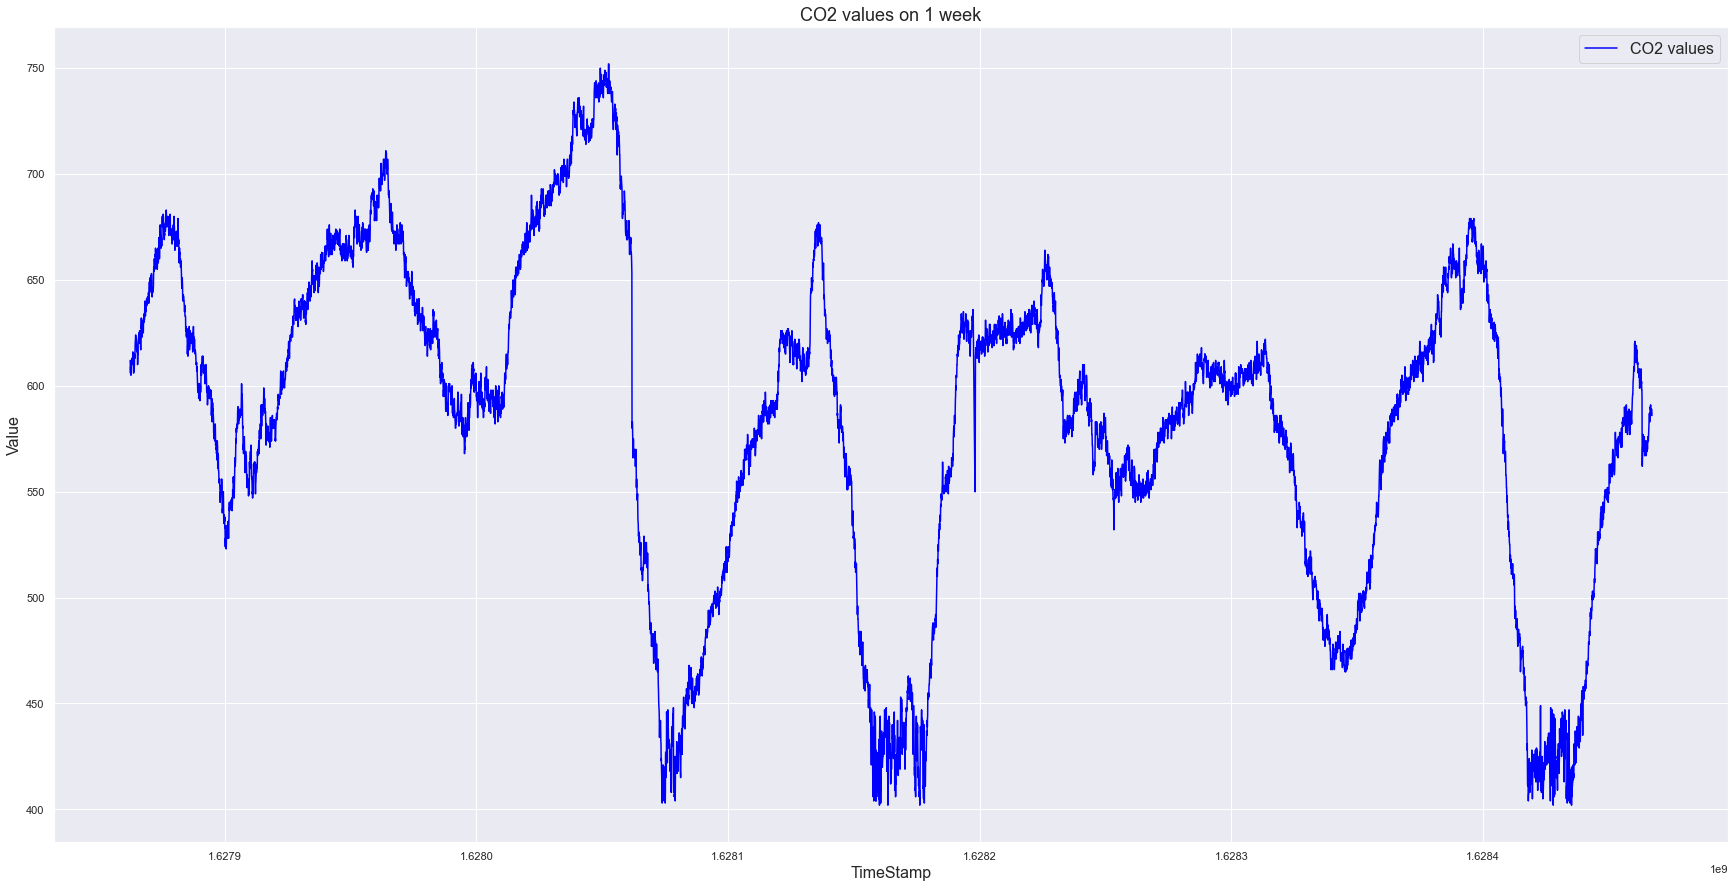

In [53]:
import matplotlib.pyplot as plt
plt.close("all")
# fig = plt.figure(figsize=(20,10), frameon=True)
plt.figure(figsize=(30,15))
plt.plot(data.get('time'), data.get('co2'), label="CO2 values", color = "blue")
# plt.scatter(dataframe.get('_source.TimeStamp'), dataframe.get('_source.Value'), color = "red")
plt.xlabel("TimeStamp", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.title("CO2 values on 1 week", fontsize=18)
plt.legend(fontsize=16)
# plt.savefig('plots_from_csv/CSV_Tests_1month.jpg', bbox_inches = 'tight')
plt.show()

In [54]:
#Let’s load the series we want to predict, Unique Visits, into a Forecaster object:
f = Forecaster(y=data['co2'],current_dates=data['date'])
f

Forecaster(
    DateStartActuals=2021-02-08T00:00:00.000000000
    DateEndActuals=2021-08-08T23:59:00.000000000
    Freq=None
    N_actuals=10070
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [55]:
#This shows we have 2,167 daily observations from 9/14/2014 through 8/19/2020 to forecast with.
#The first thing we should do after initializing the object is set its test length. We can choose a number of observations to use by passing an int to the function below,
#or split the data fractionally by passing a float between 0 and 1.
f.set_test_length(.2)

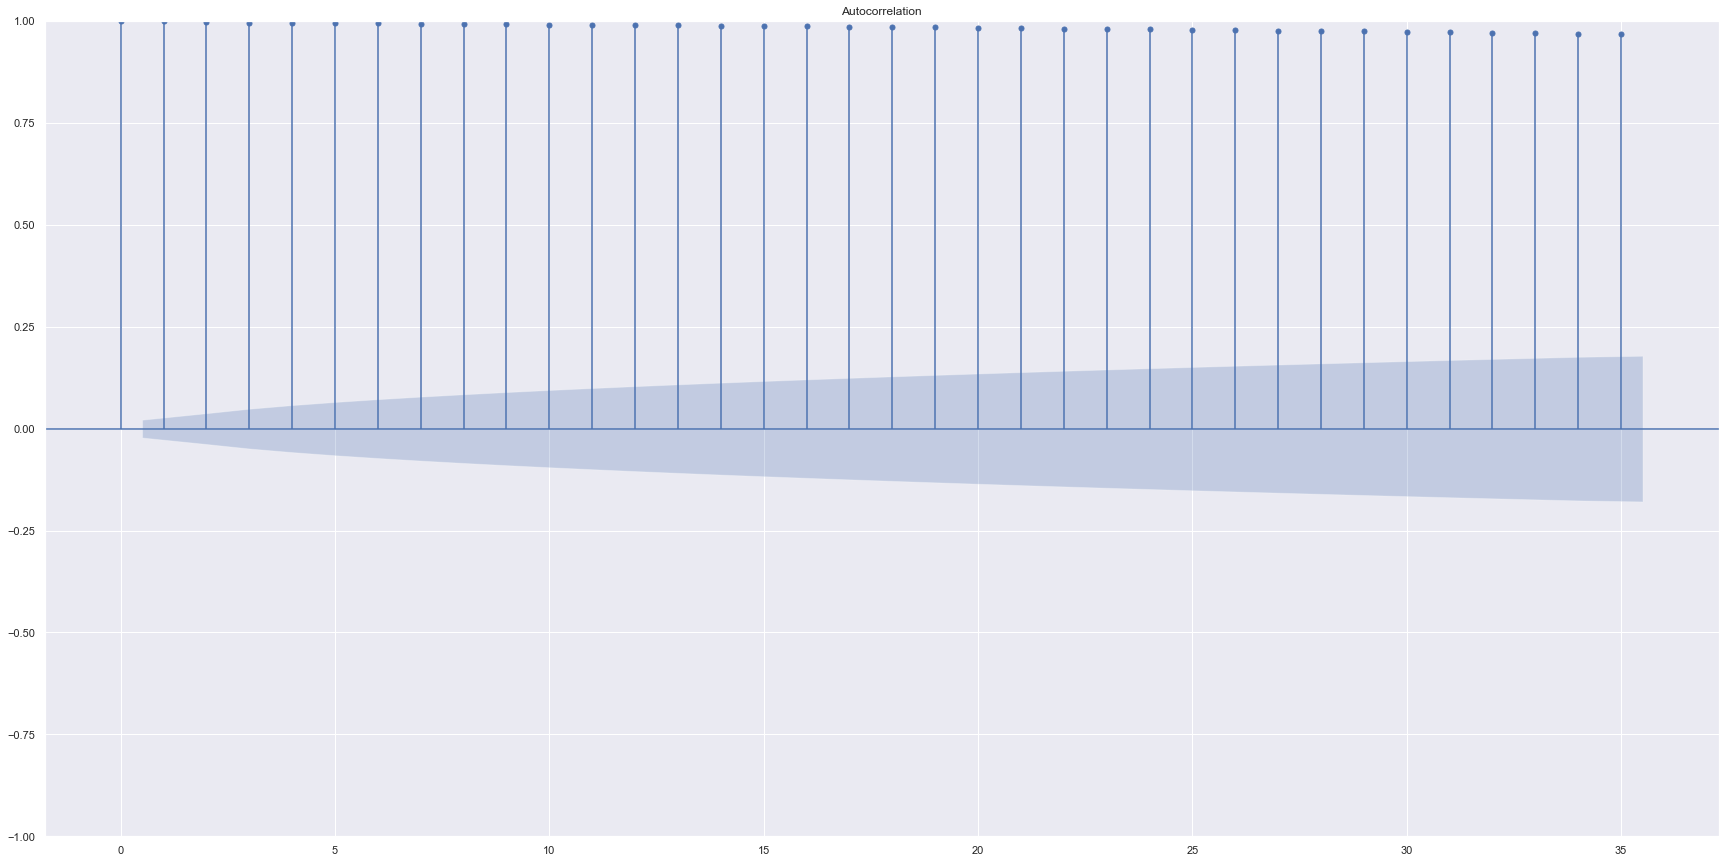

In [56]:
#Before beginning the forecasting process, we should get a better idea of the signals within the time series itself. 
#Using ACF, PACF, and Periodogram plots, we can observe how the series is auto-correlated. We can leave the test set out of all visualizations (train_only=True) 
#to not leak data when making decisions about which signals exist in the data.
f.plot_acf(train_only=True,lags=35)
plt.show()

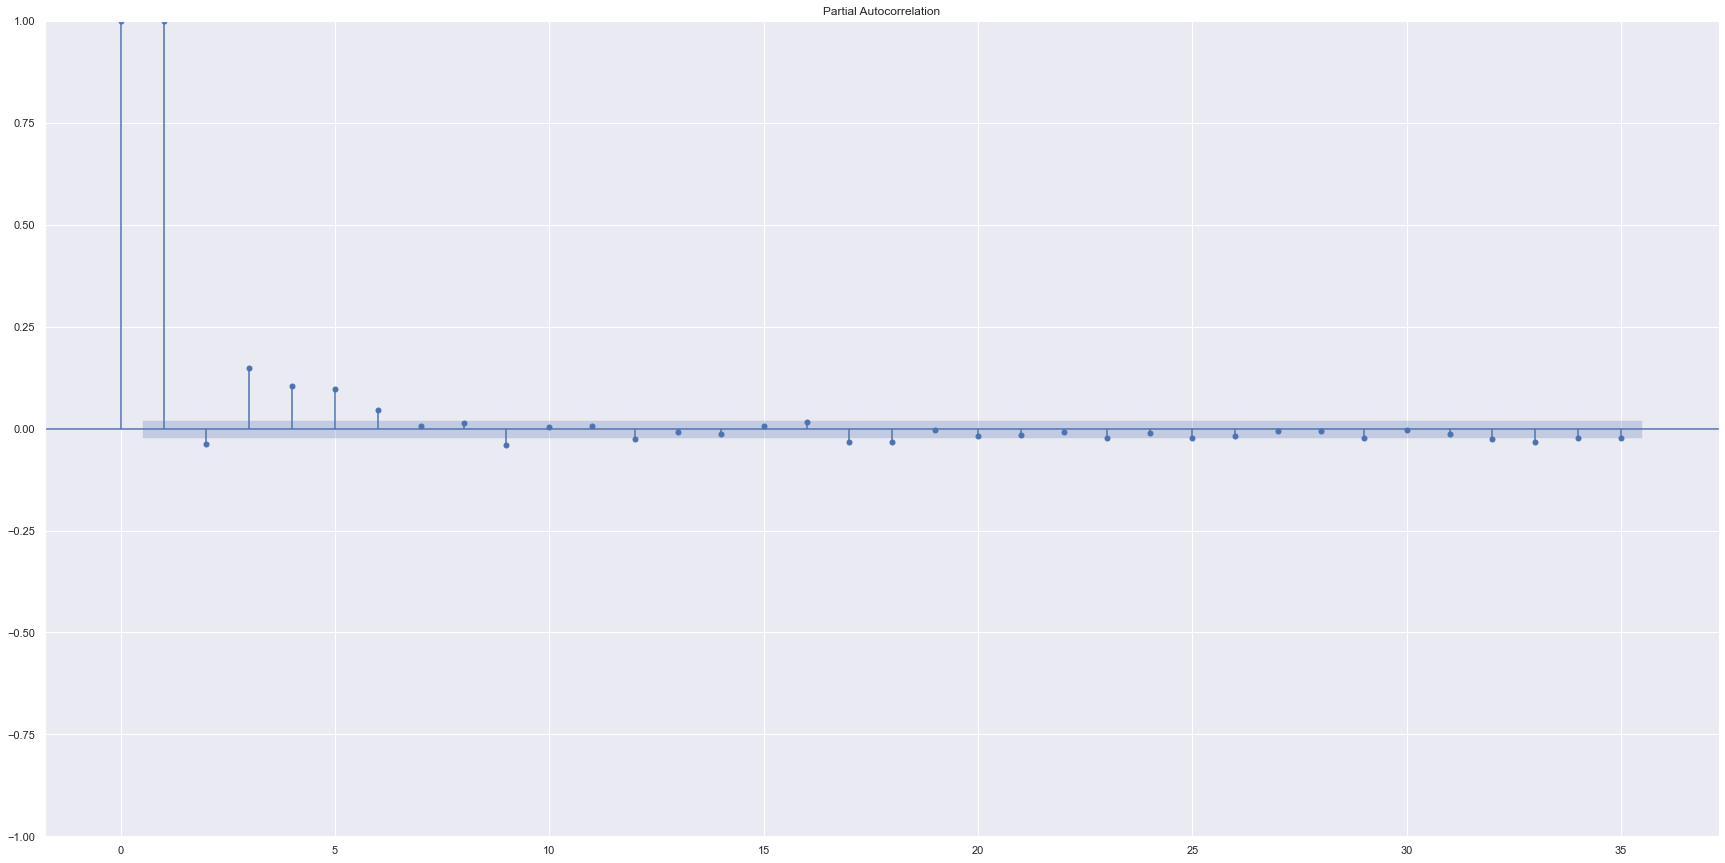

In [57]:
f.plot_pacf(train_only=True,lags=35)
plt.show()

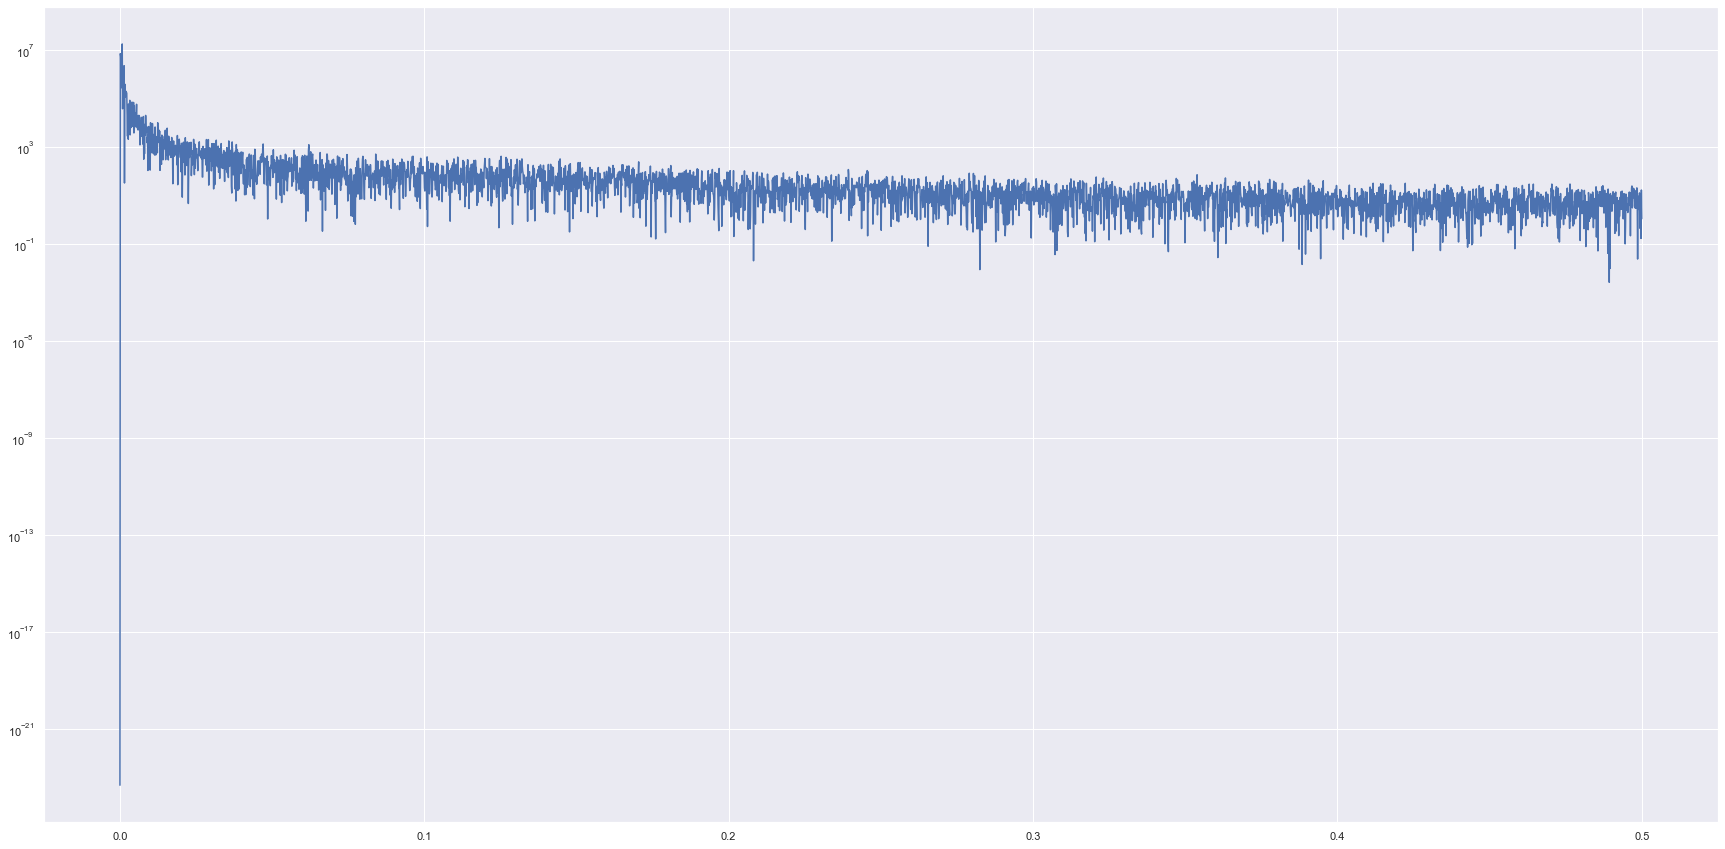

In [58]:
a, b = f.plot_periodogram(train_only=True)
plt.semilogy(a, b)
plt.show()

In [59]:
#There might be some drift in the data.
# f.seasonal_decompose(train_only=True).plot()
# plt.show()

In [60]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -2.65
the p-value is 0.0824
the series is not stationary
----------------------------------------------------------------------------------------------------


In [61]:
f.generate_future_dates(60) # forecast horizon
f.set_validation_length(60) # validation set length for tuning hyperparameters
f.add_ar_terms(7) # 7 dep variable lags
f.add_AR_terms((5,7)) # 5 weekly seasonaly dep variable lags
f.add_seasonal_regressors(
    'month',
    'quarter',
    'week',
    'dayofyear',
    raw=False,
    sincos=True) # wave-form seasonality
f.add_seasonal_regressors(
    'dayofweek',
    'week',
    raw=False,
    dummy=True,
    drop_first=True
) # dummy variable seasonality
f.add_seasonal_regressors('year') # yearly trend
f

Forecaster(
    DateStartActuals=2021-02-08T00:00:00.000000000
    DateEndActuals=2021-08-08T23:59:00.000000000
    Freq=None
    N_actuals=10070
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'AR35', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_3', 'dayofweek_5', 'dayofweek_6', 'week_14', 'week_18', 'week_23', 'week_27', 'week_31', 'week_6', 'year']
    Differenced=0
    TestLength=2014
    ValidationLength=60
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [62]:
f.set_estimator('prophet')
f.manual_forecast()

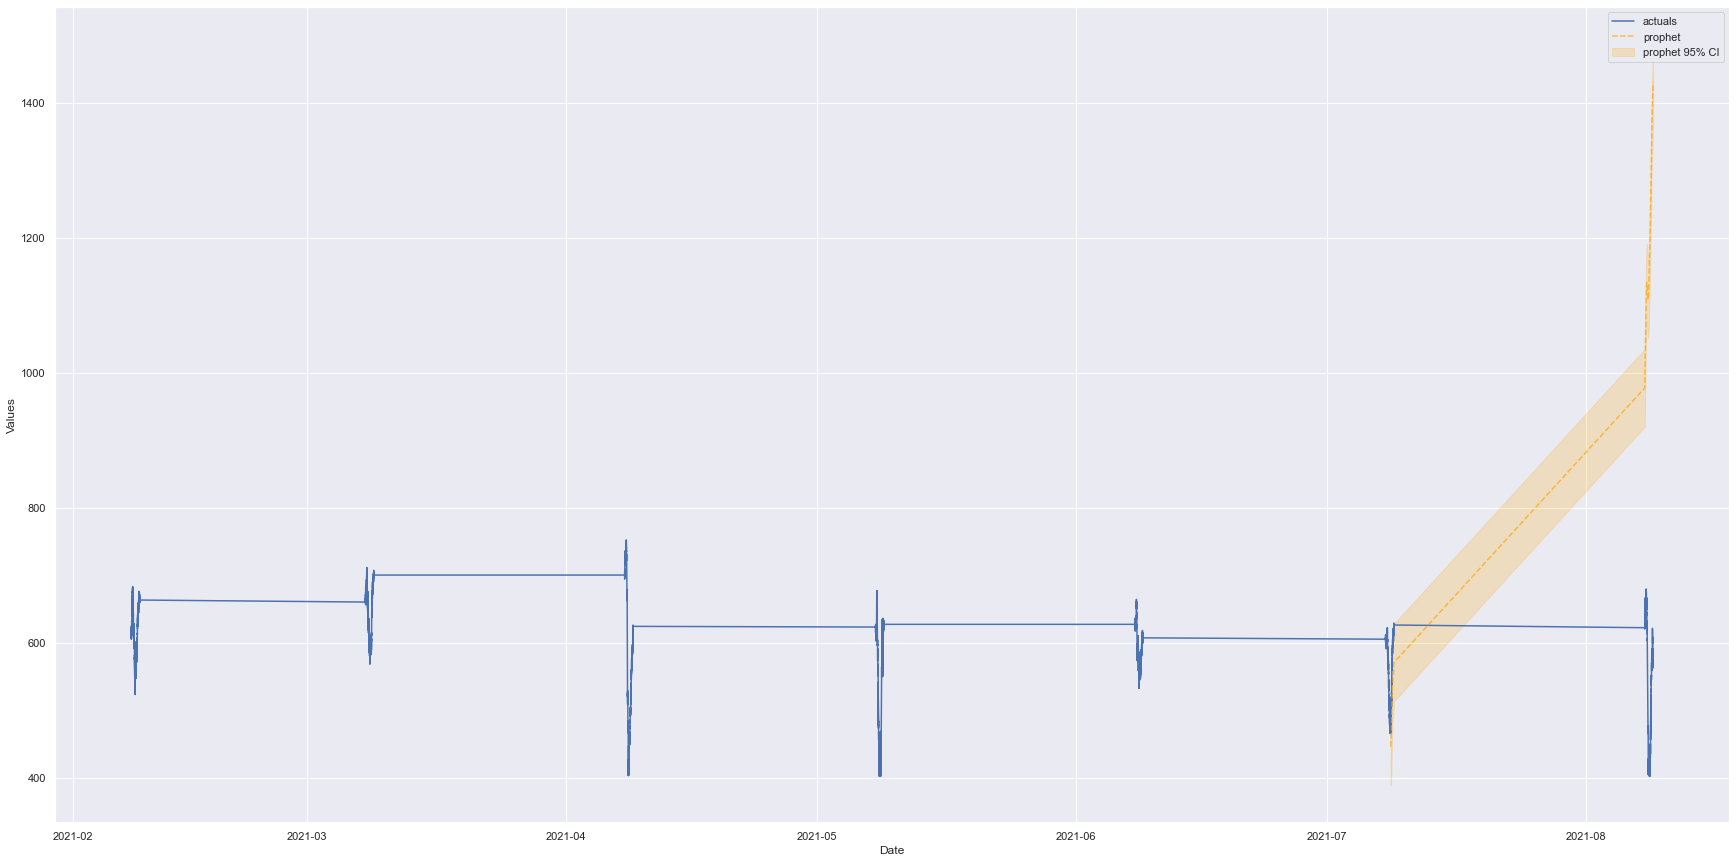

In [63]:
f.plot_test_set(ci=True,models='prophet')
plt.show()